# PSF Check

In [1]:
from gammapy.cube import PSFMap
from gammapy.irf import EnergyDependentTablePSF

In [204]:
from pathlib import Path

from astropy.coordinates import SkyCoord
from gammapy.maps import WcsGeom
from gammapy.modeling.models import (
    Models,
    PointSpatialModel,
    PowerLawSpectralModel,
    SkyModel,
)
from gammapy.data import GTI, Observation, EventList
from gammapy.maps import MapAxis, WcsGeom, Map, MapCoord
from gammapy.maps.profile import ImageProfile, ImageProfileEstimator
from gammapy.irf import EnergyDispersion2D, PSF3D, EnergyDependentMultiGaussPSF, load_cta_irfs

from gammapy.cube import (
    MapDataset,
    MapDatasetEventSampler,
    MapDatasetMaker,
)


In [234]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import astropy.units as u


In [4]:
def get_filename_dataset(livetime):
    filename = f"data/dataset_{livetime.value:.0f}{livetime.unit}.fits.gz"
    return BASE_PATH / filename


def get_filename_events(filename_dataset, filename_model, obs_id):
    obs_id=int(obs_id)
    model_str = filename_model.name.replace(filename_model.suffix, "")
    filename_events = filename_dataset.name.replace("dataset", "events")
    filename_events = BASE_PATH / f"data/models/{model_str}/" / filename_events
    filename_events = filename_events.name.replace(".fits.gz", f"_{obs_id:04d}.fits.gz")
    path = BASE_PATH / f"data/models/{model_str}/" / filename_events
    return path


In [359]:
def gaussian(x, amp, wid):
    return amp * np.exp(-(x)**2 / (2*wid**2.))


In [5]:
BASE_PATH = Path("../make.py").parent

In [6]:
model = "point-pwlsimple"
filename_model = BASE_PATH / f"models/{model}.yaml"


In [7]:
IRF_FILE = "$GAMMAPY_DATA/cta-1dc/caldb/data/cta/1dc/bcf/South_z20_50h/irf_file.fits"
POINTING = SkyCoord(0.0, 0.5, frame="galactic", unit="deg")
LIVETIME = 10 * u.hr
GTI_TABLE = GTI.create(start=0 * u.s, stop=LIVETIME.to(u.s))

# dataset config
ENERGY_AXIS = MapAxis.from_energy_bounds("0.1 TeV", "100 TeV", nbin=10, per_decade=True)
ENERGY_AXIS_TRUE = MapAxis.from_energy_bounds("0.03 TeV", "300 TeV", nbin=20, per_decade=True)
MIGRA_AXIS = MapAxis.from_bounds(0.5, 2, nbin=150, node_type="edges", name="migra")

WCS_GEOM = WcsGeom.create(
    skydir=POINTING, width=(4, 4), binsz=0.02, frame="galactic", axes=[ENERGY_AXIS]
)


### Create the dataset

In [274]:
irfs = load_cta_irfs(IRF_FILE)

observation = Observation.create(
                                 obs_id=1001, pointing=POINTING, livetime=LIVETIME, irfs=irfs
                                 )

empty = MapDataset.create(WCS_GEOM, energy_axis_true=ENERGY_AXIS_TRUE, migra_axis=MIGRA_AXIS)
#    maker = MapDatasetMaker(selection=["exposure", "edisp"])
#    maker = MapDatasetMaker(selection=["exposure", "edisp", "background"])
maker = MapDatasetMaker(selection=["exposure"])
dataset = maker.run(empty, observation)


In [275]:
# print(dataset.models)

In [276]:
# a=dataset.npred()

In [277]:
# a.plot_interactive()

In [278]:
models = Models.read(filename_model)

In [280]:
# print(models)

In [281]:
dataset.models = models

In [282]:
# print(dataset.npred())

In [284]:
sampler = MapDatasetEventSampler(random_state=0)
observation = Observation.create(
    obs_id=1001, pointing=POINTING, livetime=LIVETIME, irfs=irfs
)

events = sampler.run(dataset, observation)


In [285]:
events.table

ENERGY_TRUE,RA_TRUE,DEC_TRUE,TIME,MC_ID,RA,DEC,ENERGY,EVENT_ID
TeV,deg,deg,s,,deg,deg,TeV,
float64,float64,float64,float64,int64,float64,float64,float64,int64
0.4810854600091019,266.3864001019041,-28.937224624952275,10495.205614948645,1,266.3864001019041,-28.937224624952275,0.4810854600091019,0
0.07353832387408077,266.39549386129556,-28.91877821800499,22614.145982195623,1,266.39549386129556,-28.91877821800499,0.07353832387408077,1
2.3042256215233072,266.4002010372554,-28.953632706869026,25716.66746553965,1,266.4002010372554,-28.953632706869026,2.3042256215233072,2
0.47121276266498574,266.3840622149844,-28.93564158259355,9813.168279477395,1,266.3840622149844,-28.93564158259355,0.47121276266498574,3
1.9408190047954321,266.38152775664753,-28.94539147274147,4199.0702567389235,1,266.38152775664753,-28.94539147274147,1.9408190047954321,4
0.2414723853341287,266.413392364421,-28.931775503229478,18370.984217477962,1,266.413392364421,-28.931775503229478,0.2414723853341287,5
0.1634274035969091,266.38624148748943,-28.928162212551868,10187.255415692925,1,266.38624148748943,-28.928162212551868,0.1634274035969091,6
0.9711605822550461,266.3984456128507,-28.910843348961237,11708.105075522326,1,266.3984456128507,-28.910843348961237,0.9711605822550461,7


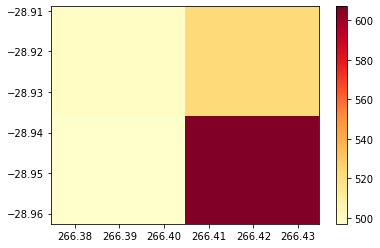

In [286]:
plt.hist2d(events.table['RA_TRUE'],events.table['DEC_TRUE'], bins=2, cmap=plt.cm.YlOrRd)
plt.colorbar()

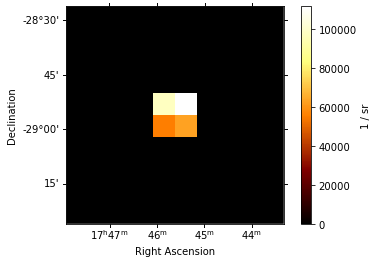

In [287]:
model = PointSpatialModel(lon_0="0.01deg", lat_0="0.01 deg", frame="galactic",)

geom = WcsGeom.create(
    skydir=SkyCoord("0d 0d", frame="galactic"), width=(1, 1), binsz=0.1
)
model.plot(geom=geom, add_cbar=True)


### Compare the PSF

In [155]:
# # psf_mod = PSF3D(0.01*u.TeV, 300*u.TeV, offset=[0, 2, 4, 6, 8] * u.deg, rad_lo=0.5*u.deg, rad_hi=0.5*u.deg, 
#                 psf_value=(0.006/u.deg)**2)

In [156]:
# psf_mod.plot_containment()

In [288]:
psf_gauss = EnergyDependentMultiGaussPSF.read(filename=IRF_FILE, hdu="POINT SPREAD FUNCTION")
# psf_gauss = EnergyDependentMultiGaussPSF(energy_lo=0.01*u.TeV, energy_hi=200*u.TeV, 
#                                          theta=[0, 2, 4, 6, 8] * u.deg, sigmas=[[0.1,0.1,0.1]]*u.deg,
#                                         norms=[1,1,1])
psf_3d = psf_gauss.to_psf3d(rad=np.linspace(0, 1, 100) * u.deg)

In [290]:
# psf_3d.plot_psf_vs_rad()

In [291]:
irfs = load_cta_irfs(IRF_FILE)

irfs['psf'] = psf_3d

observation = Observation.create(
                                 obs_id=1001, pointing=POINTING, livetime=LIVETIME, irfs=irfs
                                 )

empty = MapDataset.create(WCS_GEOM, energy_axis_true=ENERGY_AXIS_TRUE, migra_axis=MIGRA_AXIS)
#    maker = MapDatasetMaker(selection=["exposure", "edisp"])
#    maker = MapDatasetMaker(selection=["exposure", "edisp", "background"])
maker = MapDatasetMaker(selection=["exposure", "psf"])
dataset = maker.run(empty, observation)


In [292]:
dataset.models = models
sampler = MapDatasetEventSampler(random_state=0)
observation = Observation.create(
    obs_id=1001, pointing=POINTING, livetime=LIVETIME, irfs=irfs
)

events = sampler.run(dataset, observation)


In [293]:
src_pos = SkyCoord(0*u.deg, 0.0*u.deg, frame='galactic')
evt_pos = SkyCoord(events.table['RA_TRUE'], events.table['DEC_TRUE'], frame='icrs')

In [307]:
c = MapCoord.create(evt_pos)
# print(c)

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.colorbar.Colorbar at 0x12e373908>)

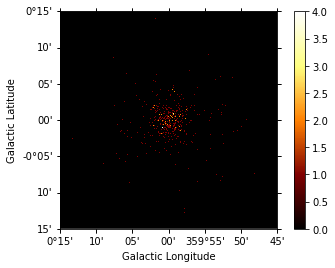

In [371]:
counts = Map.create(frame="galactic", skydir=(0, 0.), binsz=0.001, npix=(500, 500))
counts.fill_events(events)
counts.plot(add_cbar=True)

In [360]:
p = ImageProfileEstimator(axis='lon', method='sum')
profile = p.run(counts)

In [361]:
# gaussian(profile.table['x_ref'])
y = np.where(profile.table['profile']<=0, 1, profile.table['profile'])

In [362]:
profile.table

x_min,x_max,x_ref,profile
deg,deg,deg,
float64,float64,float64,float64
0.30000000000001137,0.28000000000000114,0.29000000000000625,1.0
0.28000000000000114,0.2599999999999909,0.269999999999996,0.0
0.2599999999999909,0.2400000000000091,0.25,1.0
0.2400000000000091,0.21999999999999886,0.23000000000000398,3.0
0.21999999999999886,0.19999999999998863,0.20999999999999375,2.0
0.19999999999998863,0.18000000000000682,0.18999999999999773,4.0
0.18000000000000682,0.1599999999999966,0.1700000000000017,5.0
0.1599999999999966,0.13999999999998636,0.14999999999999147,7.0


In [366]:
init_vals = [800, 0.1]

In [367]:
best_vals, covar = curve_fit(gaussian, profile.table['x_ref'], y, 
                             p0=init_vals, sigma=y**0.5)
print(best_vals)

[4.77810455e+02 3.16669229e-02]


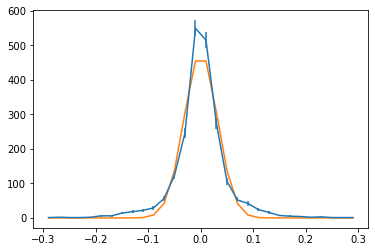

In [368]:
# smoothed = profile.smooth(kernel='gauss')
# smoothed.peek()
plt.errorbar(profile.table['x_ref'], y, yerr=y**0.5)
plt.plot(profile.table['x_ref'], gaussian(profile.table['x_ref'],*best_vals))
plt.show()


In [187]:
sep = src_pos.separation(evt_pos).value

(array([ 34.,  98., 149., 210., 323., 366., 439., 307., 152.,  50.]),
 array([6.83724036e-05, 2.86473120e-03, 5.66108999e-03, 8.45744879e-03,
        1.12538076e-02, 1.40501664e-02, 1.68465252e-02, 1.96428840e-02,
        2.24392428e-02, 2.52356016e-02, 2.80319603e-02]),
 <a list of 10 Patch objects>)

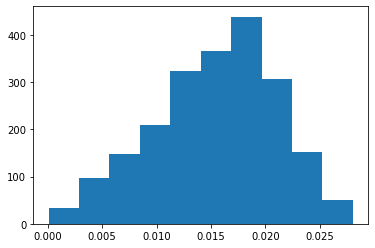

In [188]:
plt.hist(sep)

In [189]:
theta_axis = MapAxis.from_bounds(0, 0.5, nbin=100, unit="deg", name="theta")

psf_value = psf_3d.evaluate(energy=1 * u.TeV, offset=0 * u.deg, rad=theta)
psf_value = psf_value / psf_value.sum()

psf_hist, vals = np.histogram(coords, theta_axis.edges)
plt.step(theta, psf_hist / psf_hist.sum());
plt.plot(theta, psf_value.squeeze())
plt.semilogy()
plt.ylim(1e-6, 1)
plt.xlim(0, 0.2)

NameError: name 'theta' is not defined